# THESIS NS: DATA EXPLORATION

This notebook accompanies the thesis on turnover time prediction. It contains the code for most visualisations depicted in the thesis, in addition to some plots not shown there. The notebook starts with some preprocessing steps and then presents various visualisations for each input variable in the dataset. It condiders both the turnover dataset as the original dataset, utilising only 1 week of data.

In [1]:
from time import time
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder
from utils import preprocessing as prep

In [2]:
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

## 1. Load Data

Load the full dataset and the turnover dataset:

In [3]:
df_full = pd.read_csv("Data.csv", low_memory = False) # Complete data, only for comparison and visualisation

## 2. Preprocessing

Some preprocessing steps are taken here so that the unfiltered datframe can be compared to the datframe containing only turnovers.

In [8]:
turnover_df = prep.set_types(df_full)

In [9]:
turnover_df = prep.calc_turnover(turnover_df)

C:\Users\Gebruiker\Documents\CODE\Master\Thesis\Local_Testing\utils\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan["PLAN_TURNOVER_TIME"] = plan_turnover_time
C:\Users\Gebruiker\Documents\CODE\Master\Thesis\Local_Testing\utils\preprocessing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan["REALIZED_TURNOVER_TIME"] = real_turnover_time
C:\Users\Gebruiker\Documents\CODE\Master\Thesis\Local_Testing\utils\preprocessing.py:38: SettingWithCopyWarning: 
A value is trying to be 

In [10]:
turnover_df = prep.calc_needed_turnover(turnover_df)

In [11]:
turnover_df = prep.remove_unnecessary_rows(turnover_df)

Calculate signal safe delay:

In [12]:
turnover_df["PLAN_SIGNAL_SAFE_DELAY"] = (turnover_df["DEPARTURE_SIGNAL_SHOWS_SAFE"] - turnover_df["PLAN_DATETIME"]).dt.total_seconds()
df_full["REALIZED_SIGNAL_SAFE_DELAY"] = (turnover_df["DEPARTURE_SIGNAL_SHOWS_SAFE"] - turnover_df["REALIZED_DATETIME"]).dt.total_seconds()

Transform `COMBINE`and `SPLIT` into binary values, removing NaN values in the proces:

In [13]:
turnover_df['COMBINE'] = turnover_df['COMBINE'].notna().astype(int)
df_full['COMBINE'] = df_full['COMBINE'].notna().astype(int)

turnover_df['SPLIT'] = turnover_df['SPLIT'].notna().astype(int)
df_full['SPLIT'] = df_full['SPLIT'].notna().astype(int)

Filter dataframe for incorrect turnover values:

In [14]:
turnover_df = turnover_df[(turnover_df["PLAN_TURNOVER_TIME"] >= 30) & (turnover_df["PLAN_TURNOVER_TIME"] <= 6000)]
turnover_df = turnover_df[(turnover_df["DELAY"] >= -600) & (turnover_df["DELAY"] <= 10000)]

In [15]:
non_filtered_df = turnover_df.copy()

Filter out trains with a signal delay:

In [16]:
turnover_df = turnover_df.loc[turnover_df["PLAN_SIGNAL_SAFE_DELAY"] < 0]

## 3. Data Per Hour

Combining and splitting happens during the day and after each other:

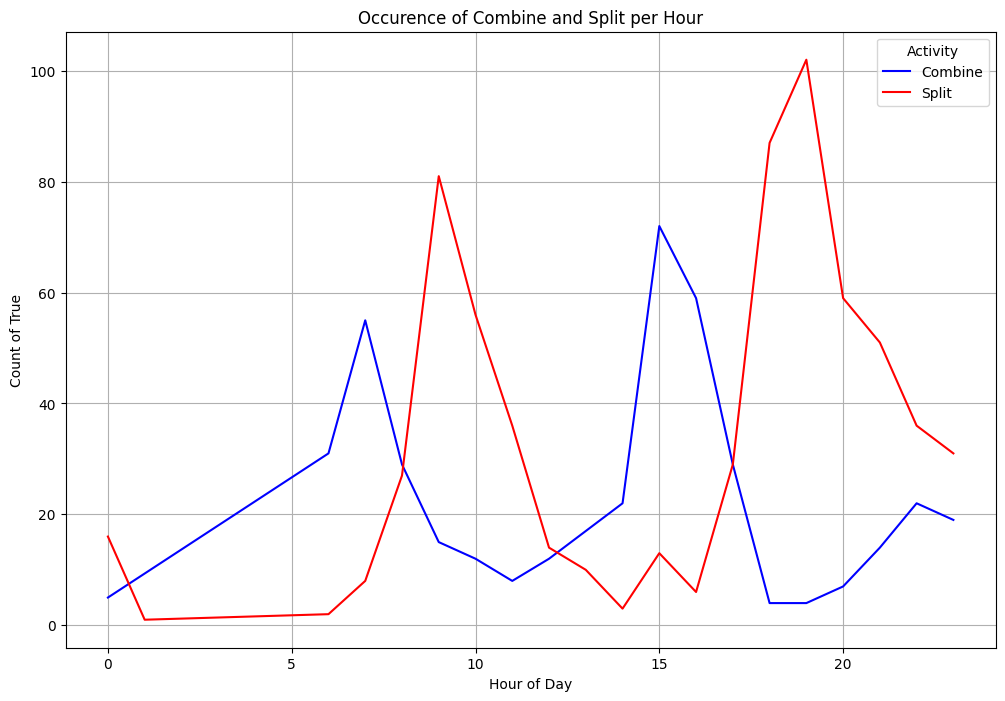

In [17]:
temp_df = turnover_df.copy()

# Create new hourly column
temp_df['Hour'] = temp_df['PLAN_DATETIME'].dt.hour

# Summarizing the counts of '1's for 'COMBINE' per hour
hourly_combine_counts = temp_df[temp_df['COMBINE'] == 1].groupby('Hour').size()

# Summarizing the counts of '1's for 'SPLIT' per hour
hourly_split_counts = temp_df[temp_df['SPLIT'] == 1].groupby('Hour').size()

# plotting
plt.figure(figsize=(12, 8))

sns.lineplot(x=hourly_combine_counts.index, y=hourly_combine_counts.values, 
             color='blue', label='Combine')
sns.lineplot(x=hourly_split_counts.index, y=hourly_split_counts.values, 
             color='red', label='Split')
plt.savefig('figs/combine_split_plot.png')


plt.title('Occurence of Combine and Split per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Count of True')
plt.legend(title='Activity')
plt.grid(True)
plt.show()


Most tunrovers happen during the day,at the afternoon peak. The morning peak and night have less turnovers. Nightly turnovers are significantly longer.

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_9972\2312871926.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Hour', y='REALIZED_TURNOVER_TIME', data=temp_df, palette=colors, showfliers=False)


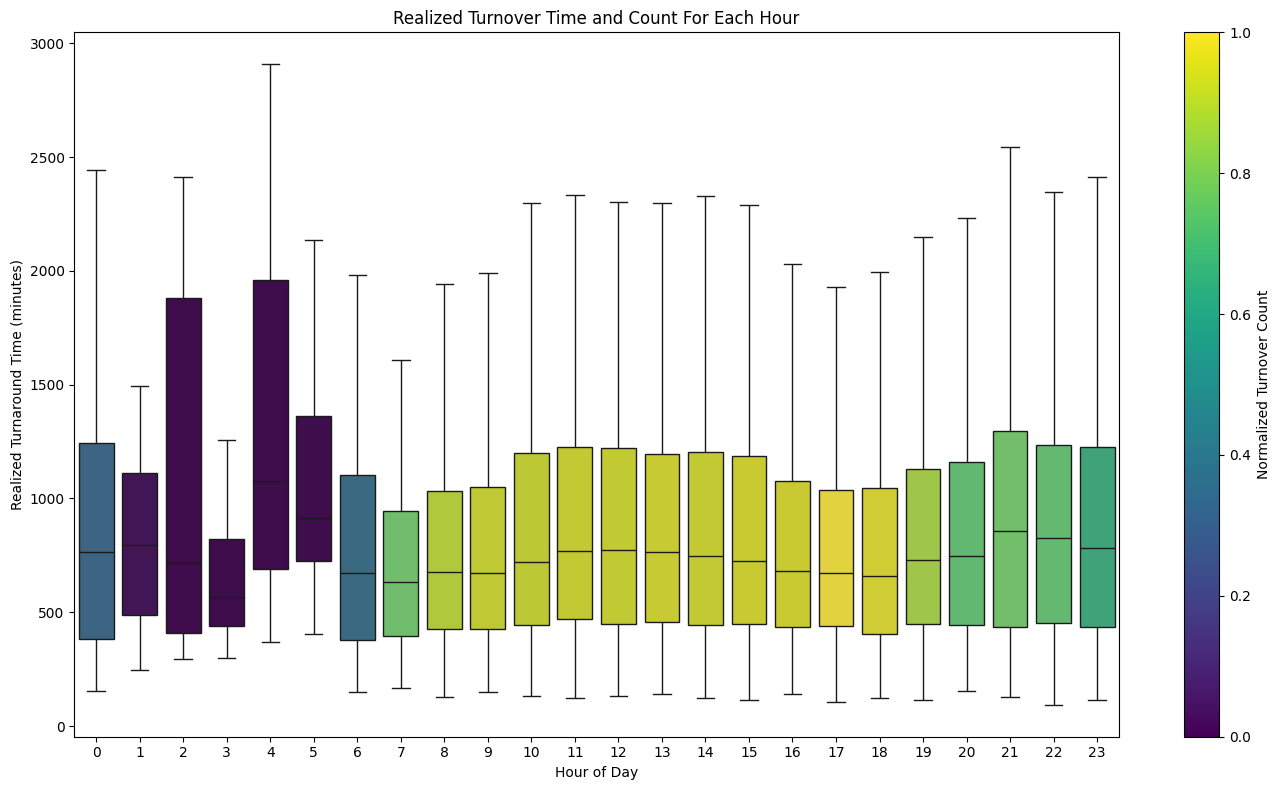

In [18]:
# Copy the dataframe
temp_df = turnover_df.copy()

# Create new hourly column
temp_df['Hour'] = temp_df['PLAN_DATETIME'].dt.hour

# Count turnarounds per hour
turnover_counts = temp_df.groupby('Hour').size()

# Normalizing the turnover counts to get a relative scale
norm_counts = (turnover_counts - turnover_counts.min()) / (turnover_counts.max() - turnover_counts.min())

# Define the color map and normalization
color_map = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=0, vmax=1)

# Create a color mappable object
sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
sm.set_array([])

# Map normalized counts to the color map
colors = {hour: color_map(norm(value)) for hour, value in norm_counts.items()}

temp_df['Hour'] = temp_df['Hour'].astype(str)
colors = {str(hour): color for hour, color in colors.items()}
# Ensure 'Hour' column is ordered chronologically
temp_df['Hour'] = pd.Categorical(temp_df['Hour'], categories=[str(i) for i in range(24)], ordered=True)

# Plotting
plt.figure(figsize=(14, 8))
ax = sns.boxplot(x='Hour', y='REALIZED_TURNOVER_TIME', data=temp_df, palette=colors, showfliers=False)

# Add the color bar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Normalized Turnover Count')
plt.savefig('figs/hour_plot.png')

# Add titles and labels
plt.title('Realized Turnover Time and Count For Each Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Realized Turnaround Time (minutes)')
plt.tight_layout()
plt.show()

## 3. Turnover Times

Only about 9 percent of the trains had a delay larger than 3 minutes (both early and late):

In [19]:
non_filtered_df["DIFF_TURNOVER_TIME"] = (non_filtered_df["PLAN_TURNOVER_TIME"] - non_filtered_df["REALIZED_TURNOVER_TIME"])

total_count = len(non_filtered_df)

count_between_3min_delay = len(non_filtered_df[non_filtered_df["DIFF_TURNOVER_TIME"].between(-180, 180)])

percentage = (count_between_3min_delay / total_count) * 100

print(f"Percentage of rows with DELAY < 180: {percentage:.2f}%")

Percentage of rows with DELAY < 180: 91.46%


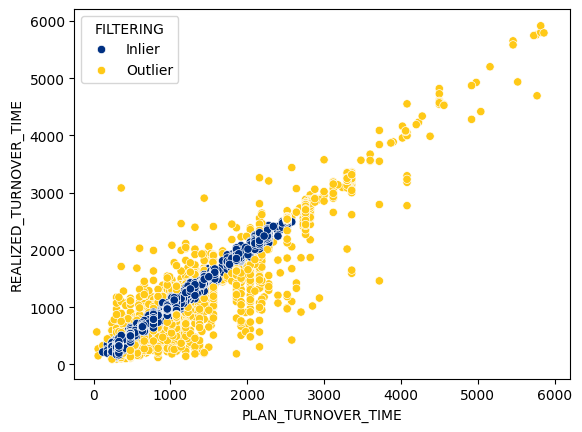

In [20]:

# Copy dataframe
temp_df = non_filtered_df.copy()

# Create the FILTERING column based on the conditions
temp_df['FILTERING'] = 'Inlier'  

# Set 'Outlier' for REALIZED_TURNOVER_TIME > 2500
temp_df.loc[temp_df['REALIZED_TURNOVER_TIME'] > 2500, 'FILTERING'] = 'Outlier'

# Set 'Outlier' for the absolute difference condition 
mask_diff = (temp_df['REALIZED_TURNOVER_TIME'] <= 2500) & (abs(temp_df['REALIZED_TURNOVER_TIME'] - temp_df['PLAN_TURNOVER_TIME']) > 180)
temp_df.loc[mask_diff, 'FILTERING'] = 'Outlier'

# Set 'Outlier' for PLAN_TURNOVER_TIME < 120
mask_plan_time = temp_df['PLAN_TURNOVER_TIME'] < 120
temp_df.loc[mask_plan_time, 'FILTERING'] = 'Outlier'

# Set 'Outlier' for REALIZED_TURNOVER_TIME < 120
mask_plan_time = temp_df['REALIZED_TURNOVER_TIME'] < 120
temp_df.loc[mask_plan_time, 'FILTERING'] = 'Outlier'

palette = {'Inlier': '#003082', 'Outlier': 
'#FFC917'}  

# Plotting the scatterplot 
fig = sns.scatterplot(data=temp_df, x="PLAN_TURNOVER_TIME", y="REALIZED_TURNOVER_TIME", hue="FILTERING", palette=palette)

ax = plt.gca()

# Get limits for x and y axis
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Set the limits of x and y axis to be the same to maintain aspect ratio
lim = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
ax.set_xlim(lim)
ax.set_ylim(lim)

plt.savefig('figs/filtering_plot.png')

plt.show()


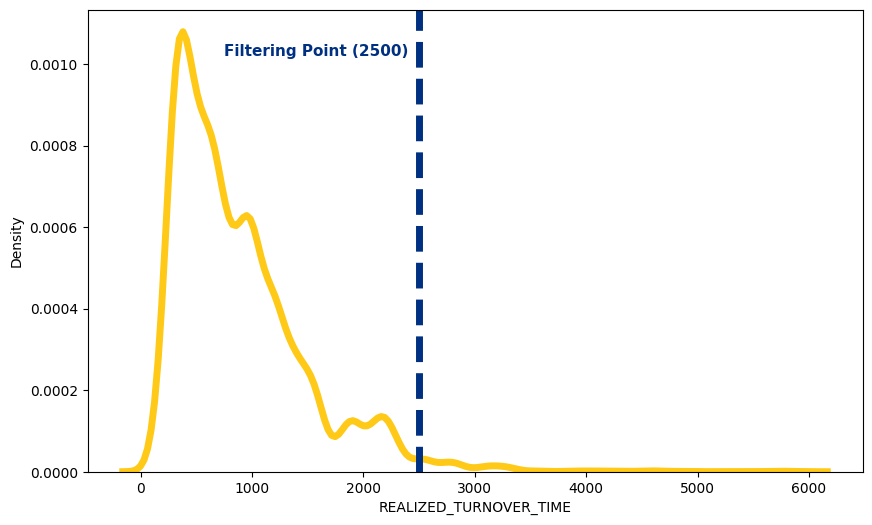

In [21]:
# Copy the dataframe
temp_df = non_filtered_df.copy()

# Create the FILTERING column based on the conditions
temp_df['FILTERING'] = 'Inlier'  

# Set 'Outlier' for REALIZED_TURNOVER_TIME > 2500
temp_df.loc[temp_df['REALIZED_TURNOVER_TIME'] > 2500, 'FILTERING'] = 'Outlier'

# Set 'Outlier' for the absolute difference condition 
mask_diff = (temp_df['REALIZED_TURNOVER_TIME'] <= 2500) & (abs(temp_df['REALIZED_TURNOVER_TIME'] - temp_df['PLAN_TURNOVER_TIME']) > 180)
temp_df.loc[mask_diff, 'FILTERING'] = 'Outlier'

# Set 'Outlier' for PLAN_TURNOVER_TIME < 120
mask_plan_time = temp_df['PLAN_TURNOVER_TIME'] < 120
temp_df.loc[mask_plan_time, 'FILTERING'] = 'Outlier'

# Set 'Outlier' for REALIZED_TURNOVER_TIME < 120
mask_plan_time = temp_df['REALIZED_TURNOVER_TIME'] < 120
temp_df.loc[mask_plan_time, 'FILTERING'] = 'Outlier'

# Define colors for the plot
kde_color = '#FFC917'  
line_color = '#003082'  

# Create the distribution plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=temp_df, x='REALIZED_TURNOVER_TIME', color=kde_color, linewidth=5)  # Increased linewidth

# Add a vertical dashed line at 2500
plt.axvline(x=2500, color=line_color, linestyle='--', linewidth=5)  # Increased linewidth

# Add text around the line
x_text = 2400  
y_text = plt.gca().get_ylim()[1] * 0.9  

plt.text(x_text, y_text, 'Filtering Point (2500)', color=line_color, ha='right', fontsize=11, weight='bold')  # Increased fontsize and set weight to bold

# Set plot title and labels
plt.xlabel('REALIZED_TURNOVER_TIME')
plt.ylabel('Density')

plt.savefig('figs/distribution_plot.png')

plt.show()

After filtering, most delays are late departures instead of too early departures

Text(0, 0.5, 'Delay (seconds)')

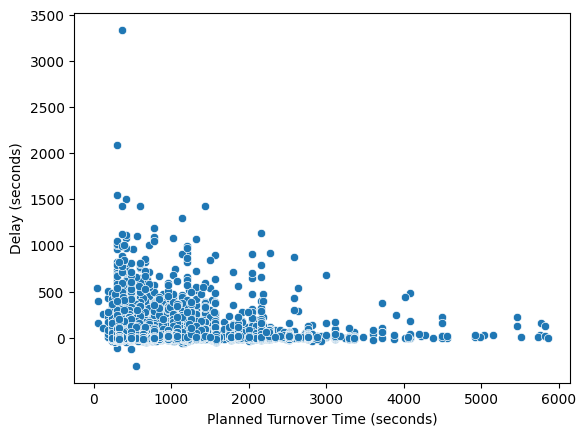

In [22]:
fig = sns.scatterplot(temp_df, x="PLAN_TURNOVER_TIME", y="DELAY")

fig.get_xaxis().set_label_text('Planned Turnover Time (seconds)')
fig.get_yaxis().set_label_text('Delay (seconds)')

About 80% of trains are on time (no delay at all):

<Axes: xlabel='ON_TIME', ylabel='count'>

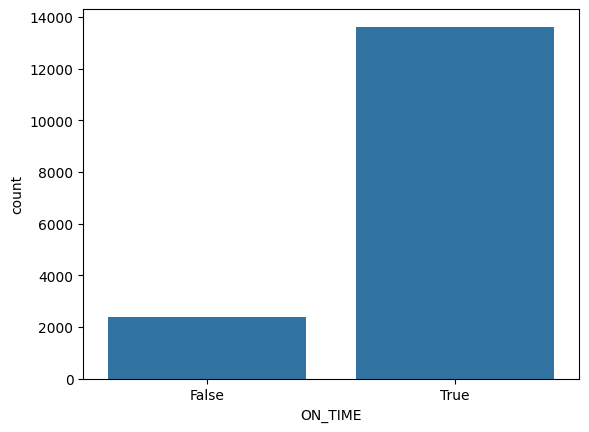

In [23]:
temp_df = turnover_df.copy()
temp_df["ON_TIME"] = np.where((temp_df["NEEDED_PLAN_TURNOVER_TIME"] >= temp_df["REALIZED_TURNOVER_TIME"]), True, False )

sns.countplot(temp_df, x = "ON_TIME")

## 3. Combining and Splitting

Combining and splitting of trains is rarely done, even during turnovers

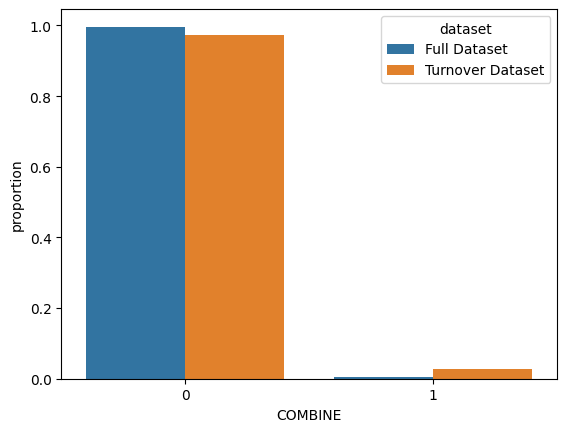

In [24]:
# Calculate proportions for the full dataset
full_counts = df_full['COMBINE'].value_counts(normalize=True).reset_index()
full_counts.columns = ['COMBINE', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['COMBINE'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['COMBINE', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'

# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])

sns.barplot(combined_data, x='COMBINE',y = 'proportion', hue = "dataset")
plt.show()

<Axes: xlabel='SPLIT', ylabel='proportion'>

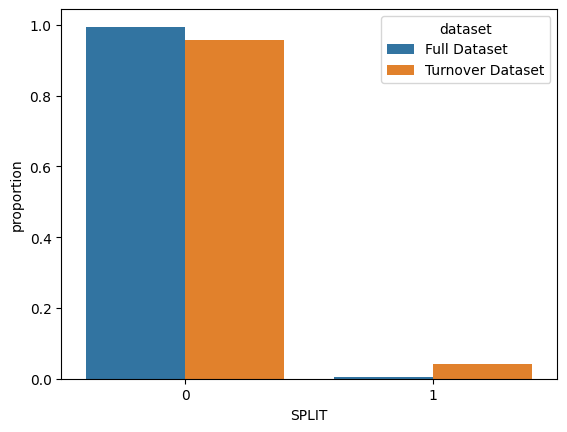

In [25]:
# Calculate proportions for the full dataset
full_counts = df_full['SPLIT'].value_counts(normalize=True).reset_index()
full_counts.columns = ['SPLIT', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['SPLIT'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['SPLIT', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'

# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])
sns.barplot(combined_data, x = "SPLIT", y = 'proportion', hue = 'dataset')

Combining and splitting have a significant influence on turnover time but they occure in very few turnovers:

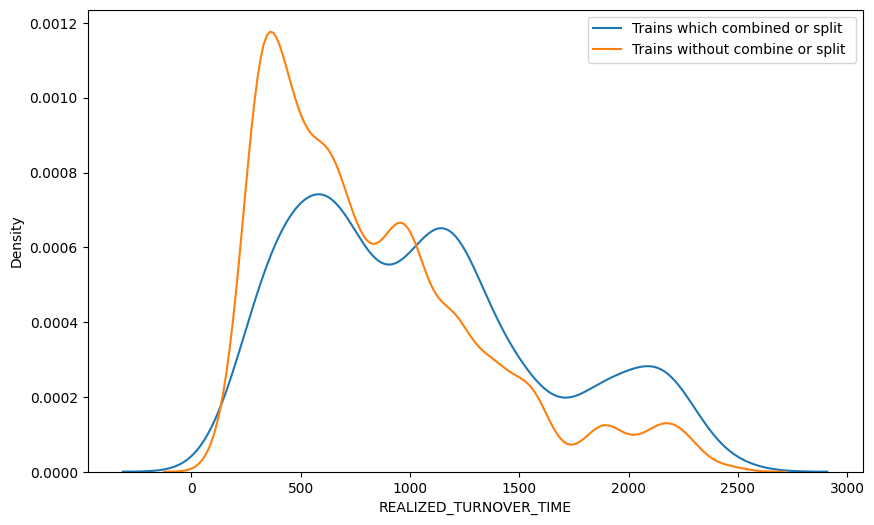

In [26]:
# Limit Turnover time
temp_df = non_filtered_df.copy()
temp_df = temp_df.loc[temp_df["REALIZED_TURNOVER_TIME"] < 2500]


# Create separate dataframes for combined/split trains
combine_and_split = temp_df[(temp_df["COMBINE"] == 1) | (temp_df["SPLIT"] == 1)]
no_combine_or_split = temp_df[(temp_df["COMBINE"] == 0) & (temp_df["SPLIT"] == 0)]
                                  
plt.figure(figsize=(10, 6))
sns.kdeplot(data=combine_and_split['REALIZED_TURNOVER_TIME'], label='Trains which combined or split')
sns.kdeplot(data=no_combine_or_split['REALIZED_TURNOVER_TIME'], label='Trains without combine or split ')

plt.xlabel('REALIZED_TURNOVER_TIME')
plt.ylabel('Density')
plt.legend()
plt.show()

In [56]:
# Calculate average and count of REALIZED_TURNOVER_TIME for combine_and_split
avg_combine_split = combine_and_split['REALIZED_TURNOVER_TIME'].mean()
count_combine_split = combine_and_split['REALIZED_TURNOVER_TIME'].count()

# Calculate average and count REALIZED_TURNOVER_TIME for no_combine_or_split
avg_no_combine_split = no_combine_or_split['REALIZED_TURNOVER_TIME'].mean()
count_no_combine_split = no_combine_or_split['REALIZED_TURNOVER_TIME'].count()



# Print the results
print(f"Average REALIZED_TURNOVER_TIME for combine_and_split: {avg_combine_split:.2f}", "seconds")
print(f"Count of combine_and_split: {count_combine_split}", "observations")

print()

print(f"Average REALIZED_TURNOVER_TIME for no_combine_or_split: {avg_no_combine_split:.2f}", "seconds")
print(f"Count of no_combine_or_split: {count_no_combine_split}", "observations")

Average REALIZED_TURNOVER_TIME for combine_and_split: 1051.78 seconds
Count of combine_and_split: 1177 observations

Average REALIZED_TURNOVER_TIME for no_combine_or_split: 825.63 seconds
Count of no_combine_or_split: 16682 observations


## 4.  Signal Safe Delay

Most of the time, a green signal delay is negative meaning that the stoplight was green earlier than the train needed to depart. There are large outliers in the original data.

<Axes: xlabel='PLAN_SIGNAL_SAFE_DELAY', ylabel='Count'>

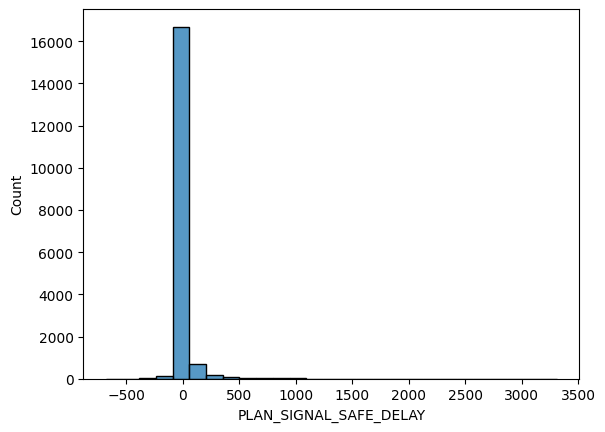

In [28]:
sns.histplot(non_filtered_df, x = "PLAN_SIGNAL_SAFE_DELAY", binwidth = 150)

Before filtering, delays follow an inverse-gamma distribution with most delays being very short.

<Axes: xlabel='DELAY', ylabel='Count'>

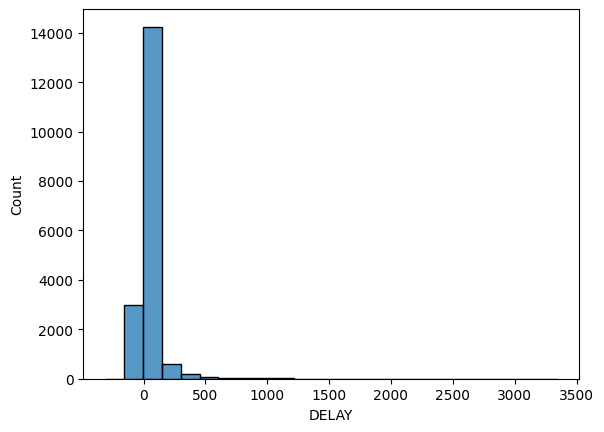

In [29]:
sns.histplot(non_filtered_df, x = "DELAY", binwidth = 150)

## 5. Rolling Stock Type

Some rolling stock types seem to perform turnovers more than others, relative to their general train movements. Still, differences are very small.

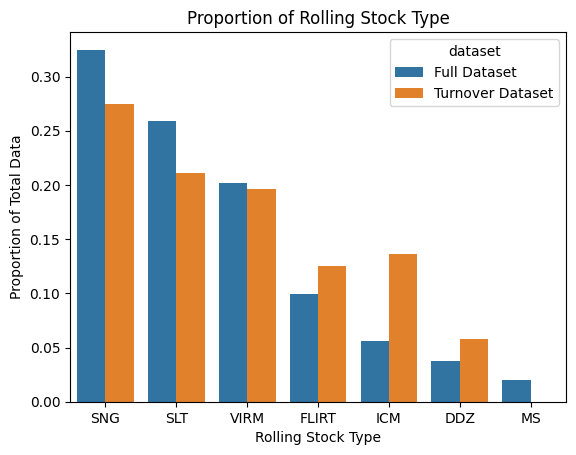

In [30]:
# Calculate proportions for the full dataset
full_counts = df_full['ROLLINGSTOCK_TYPE'].value_counts(normalize=True).reset_index()
full_counts.columns = ['ROLLINGSTOCK_TYPE', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['ROLLINGSTOCK_TYPE'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['ROLLINGSTOCK_TYPE', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'

# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])

# Create a barplot to show proportions
order = df_full['ROLLINGSTOCK_TYPE'].value_counts().index

sns.barplot(data=combined_data, x='ROLLINGSTOCK_TYPE', y='proportion', hue='dataset', order=order)

plt.title('Proportion of Rolling Stock Type')
plt.xlabel('Rolling Stock Type')
plt.ylabel('Proportion of Total Data')

plt.show()

Rollingstock type has a clear incluence on turnover time

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_9972\1409075586.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=turnover_df, x="PLAN_TURNOVER_TIME", y="ROLLINGSTOCK_TYPE", palette=colors, showfliers=False)
C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_9972\1409075586.py:4: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.boxplot(data=turnover_df, x="PLAN_TURNOVER_TIME", y="ROLLINGSTOCK_TYPE", palette=colors, showfliers=False)


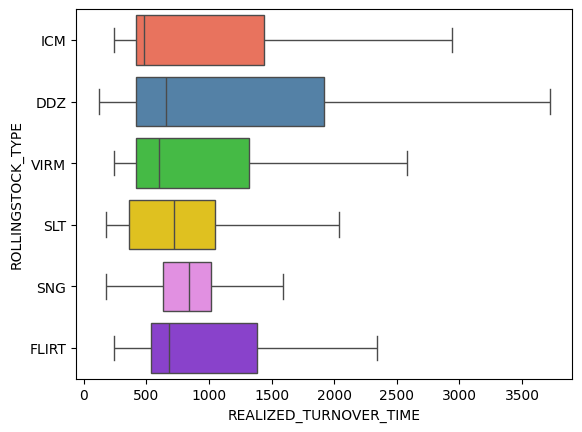

In [31]:
# Define a list of colors for the boxplots
colors = ["#FF6347", "#4682B4", "#32CD32", "#FFD700", "#EE82EE", "#8A2BE2", "#00CED1"]

sns.boxplot(data=turnover_df, x="PLAN_TURNOVER_TIME", y="ROLLINGSTOCK_TYPE", palette=colors, showfliers=False)

plt.xlabel('REALIZED_TURNOVER_TIME')
plt.ylabel('ROLLINGSTOCK_TYPE')

plt.savefig('figs/rollingstock_boxplot.png')

plt.show()


Some rollingstock types are influenced more by combining and splitting than others. In all cases, combining/splitting increases average turnover time.

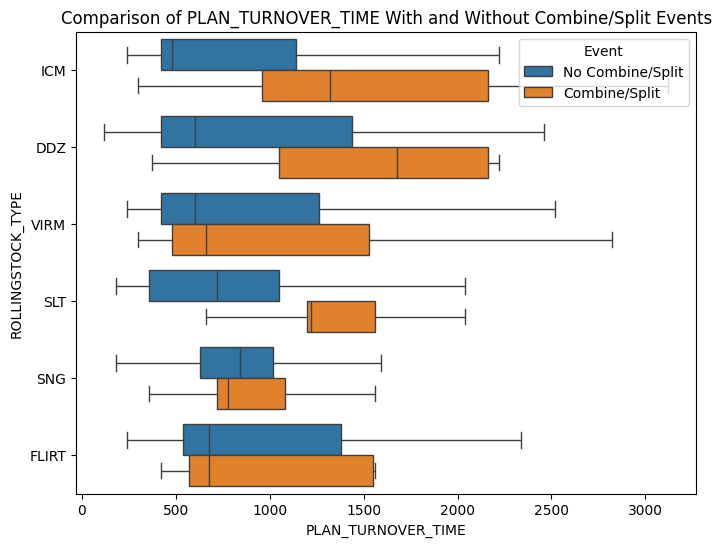

In [33]:
temp_df = turnover_df
temp_df['Event'] = np.where((temp_df['COMBINE'] == 1) | (temp_df['SPLIT'] == 1), 'Combine/Split', 'No Combine/Split')


plt.figure(figsize=(8, 6))
sns.boxplot(data=temp_df, x='PLAN_TURNOVER_TIME', y='ROLLINGSTOCK_TYPE', hue='Event', showfliers=False)
plt.title('Comparison of PLAN_TURNOVER_TIME With and Without Combine/Split Events')
plt.show()

## 6. Activity Types

Most turnovers are regular arrivals but there are some short arrivals as well.

<Axes: xlabel='ACTIVITYTYPE', ylabel='count'>

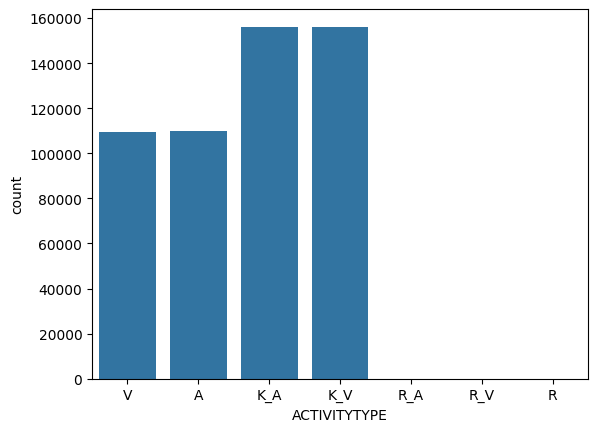

In [34]:
sns.countplot(df_full, x = "ACTIVITYTYPE")

Almost all directions are E or O, the other values are known to be outliers:

<Axes: xlabel='TRAINSERIE_DIRECTION', ylabel='count'>

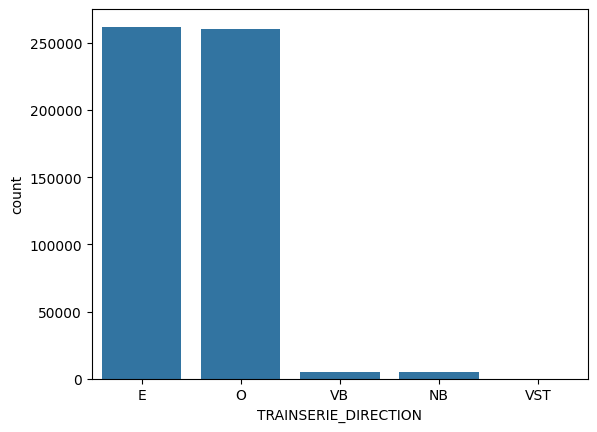

In [35]:
sns.countplot(df_full, x = "TRAINSERIE_DIRECTION")

## 7. Stations

Turnovers do not occur at all stations. Some of the busiest stations are never used for turnovers.

In [47]:
#Find the top 10 stations with the largest amount of turnovers
top_10_stations = turnover_df['STATION'].value_counts().nlargest(10)

# Calculate the total number of turnovers that happened at these 10 stations
total_turnovers_top_10 = top_10_stations.sum()

# Calculate the percentage of turnovers that happened at the 10 largest turnover stations
total_turnovers = turnover_df['STATION'].value_counts().sum()
percentage_turnovers_top_10 = (total_turnovers_top_10 / total_turnovers) * 100


print(f'Total turnovers at the top 10 stations: {total_turnovers_top_10}')
print(f'Percentage of turnovers at the top 10 stations: {percentage_turnovers_top_10:.2f}%')

print('The turnover data has {} unique stations'.format(len(turnover_df['STATION'].unique())))
print('The regular data has {} unique stations'.format(len(non_filtered_df['STATION'].unique())))

Total turnovers at the top 10 stations: 8671
Percentage of turnovers at the top 10 stations: 54.17%
The turnover data has 81 unique stations
The regular data has 92 unique stations


The turnover data has 81 unique stations
The regular data has 292 unique stations


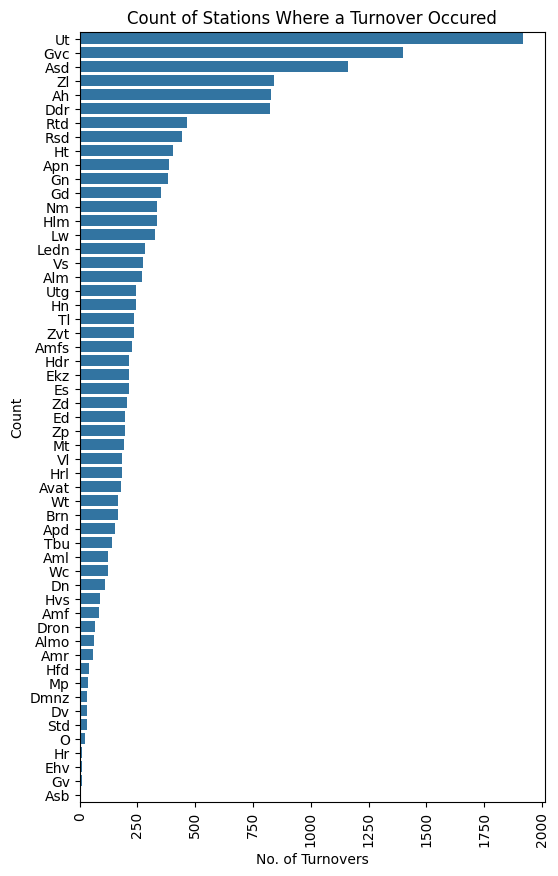

In [37]:
order = turnover_df['STATION'].value_counts().nlargest(55).index

# Inrease the figure size
plt.figure(figsize=(6, 10))  

sns.countplot(turnover_df, y = "STATION", order=order)

plt.title('Count of Stations Where a Turnover Occured')
plt.xlabel('No. of Turnovers')
plt.ylabel('Count')

plt.xticks(rotation=90)  

print('The turnover data has {} unique stations'.format(len(turnover_df['STATION'].unique())))
print('The regular data has {} unique stations'.format(len(df_full['STATION'].unique())))

plt.show()

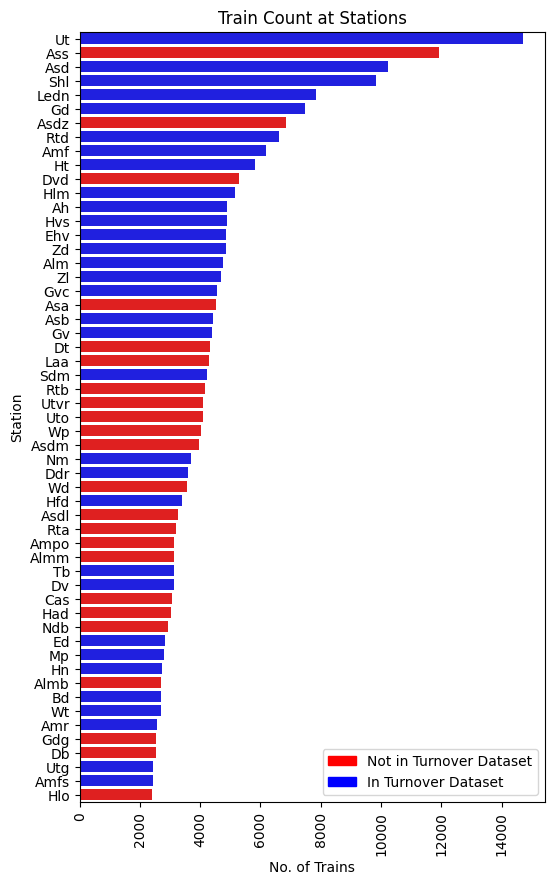

In [38]:
stations_in_turnover = set(turnover_df['STATION'])

df = df_full.copy()
# Create the 'IN_TURNOVER' column
df['IN_TURNOVER'] = df['STATION'].isin(stations_in_turnover).astype(int)

# Define color map
color_map = {0: 'red', 1: 'blue'}

# Get the order of the top 55 stations by count
order = df['STATION'].value_counts().nlargest(55).index

plt.figure(figsize=(6, 10))

# Calculate counts for the top 55 stations
station_counts = df['STATION'].value_counts().loc[order]

# Create a new DataFrame for the top 55 stations with their counts and turnover status
top_stations = df[df['STATION'].isin(order)].drop_duplicates(subset=['STATION']).set_index('STATION').loc[order]
top_stations['COUNT'] = station_counts.values

# Plot the barplot
sns.barplot(y=top_stations.index, x=top_stations['COUNT'], hue=top_stations['IN_TURNOVER'], palette=color_map, dodge=False)

# Create legend patches
legend_patches = [mpatches.Patch(color=color_map[key], label=f'{"In Turnover Dataset" if key else "Not in Turnover Dataset"}') for key in color_map]

plt.legend(handles=legend_patches)
plt.title('Train Count at Stations')
plt.xlabel('No. of Trains')
plt.ylabel('Station')
plt.xticks(rotation=90)
plt.show()



Station has a large influence on turnover times: 

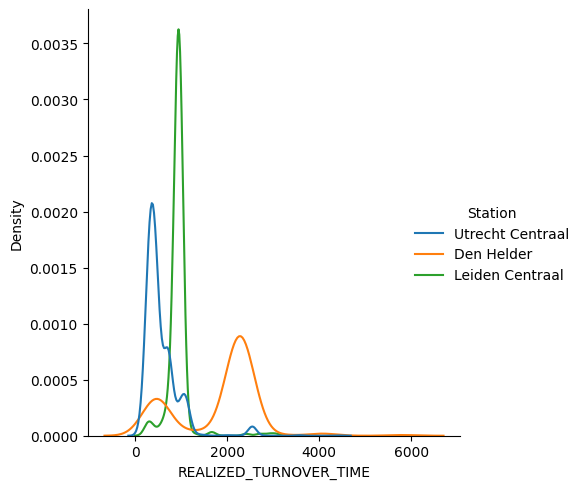

In [39]:
temp_df = turnover_df.copy()

stations = [ 'Ut', 'Hdr', 'Ledn']

temp_df = temp_df[temp_df["STATION"].isin(stations)]

g = sns.displot(temp_df, x = "REALIZED_TURNOVER_TIME", hue = "STATION", kind = 'kde',  common_norm=False, facet_kws={'legend_out': True})

# title
new_title = 'Station'
g._legend.set_title(new_title)
# replace labels
new_labels = ['Utrecht Centraal',  'Den Helder', 'Leiden Centraal', 'Groningen']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)



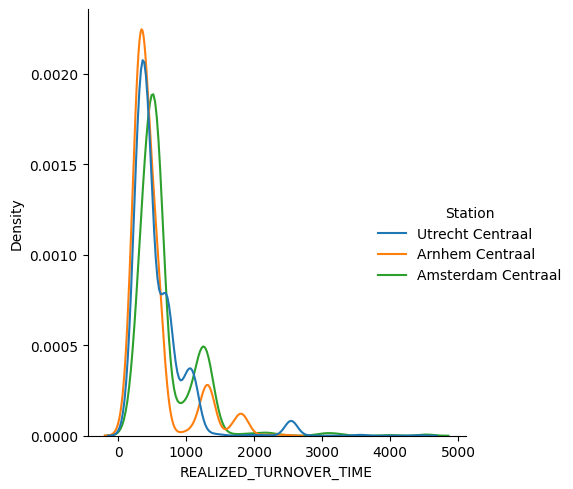

In [40]:
temp_df = turnover_df.copy()

stations = ['Ut', 'Asd', 'Ah']

temp_df = temp_df[temp_df["STATION"].isin(stations)]

g = sns.displot(temp_df, x = "REALIZED_TURNOVER_TIME", hue = "STATION", kind = 'kde',  common_norm=False)

# title
new_title = 'Station'
g._legend.set_title(new_title)
# replace labels
new_labels = ['Utrecht Centraal', 'Arnhem Centraal', 'Amsterdam Centraal']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

## 8. Rolling Stock Length

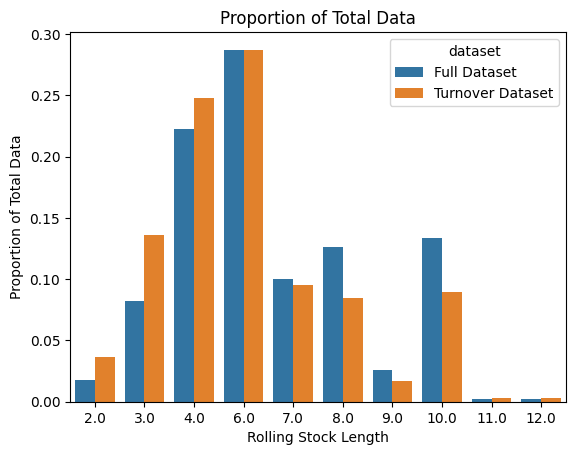

In [41]:
# Calculate proportions for the full dataset
full_counts = df_full['NUMBER_CARRIAGES'].value_counts(normalize=True).reset_index()
full_counts.columns = ['NUMBER_CARRIAGES', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['NUMBER_CARRIAGES'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['NUMBER_CARRIAGES', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'

# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])

sns.barplot(data=combined_data, x='NUMBER_CARRIAGES', y='proportion', hue='dataset')

plt.title('Proportion of Total Data')
plt.xlabel('Rolling Stock Length')
plt.ylabel('Proportion of Total Data')

plt.show()

On average, the turnover time seems to decrease with an increase in cariages, but the data also becomes smaller.

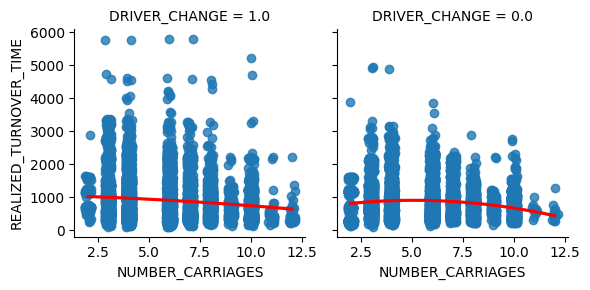

In [42]:
g = sns.FacetGrid(turnover_df, col="DRIVER_CHANGE")  
g.map(sns.regplot, "NUMBER_CARRIAGES", "REALIZED_TURNOVER_TIME", order=2, x_jitter=.15, line_kws={'color': 'red'})
plt.show()

## 9. Driver Change

In general the effect of driver changes on turnover time seems small but it becomes more relevant when looking at short turnovers.

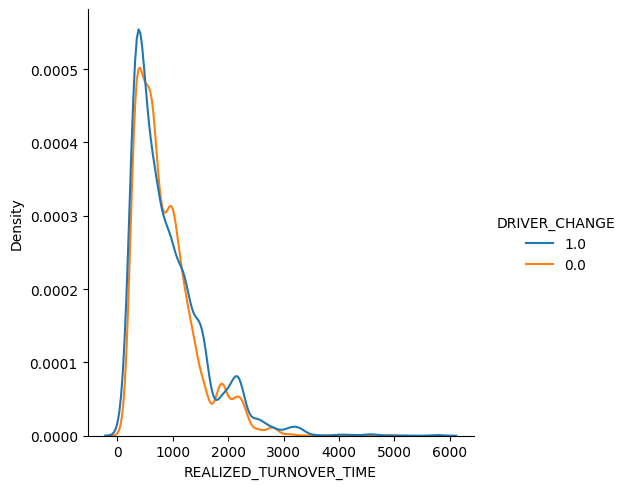

In [43]:
sns.displot(turnover_df, x = "REALIZED_TURNOVER_TIME", hue = "DRIVER_CHANGE", kind = 'kde')

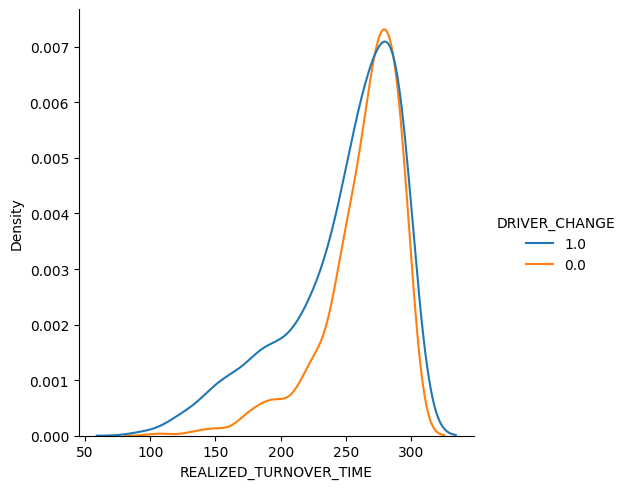

In [44]:
short_turnover_df = turnover_df[turnover_df["REALIZED_TURNOVER_TIME"] < 300]
sns.displot(short_turnover_df, x = "REALIZED_TURNOVER_TIME", hue = "DRIVER_CHANGE", kind = 'kde')

A driver change only has a positive impact when the planned turnover time is short, otherwise it has a negative impact on turnover time (on average):

In [45]:
print('Short turnovers (5 minutes or less):', )
print(short_turnover_df.groupby('DRIVER_CHANGE')['REALIZED_TURNOVER_TIME'].mean())


long_turnover_df = turnover_df[turnover_df["REALIZED_TURNOVER_TIME"] > 900]
print()

print('Long turnovers (15 minutes or more):', )
print(long_turnover_df.groupby('DRIVER_CHANGE')['REALIZED_TURNOVER_TIME'].mean())



Short turnovers (5 minutes or less):
DRIVER_CHANGE
0.0    262.742481
1.0    248.662618
Name: REALIZED_TURNOVER_TIME, dtype: float64

Long turnovers (15 minutes or more):
DRIVER_CHANGE
0.0    1393.512812
1.0    1518.015161
Name: REALIZED_TURNOVER_TIME, dtype: float64


Driver changes are more likely to occur when a turnover happens as well. NaN values are known to represent no driver change.

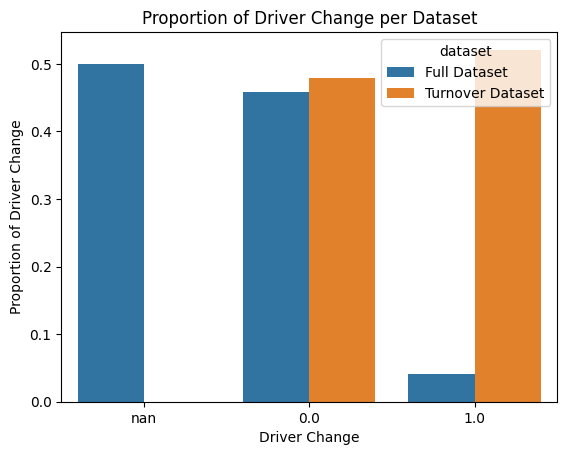

In [46]:
# Calculate proportions for the full dataset
full_counts = df_full['DRIVER_CHANGE'].value_counts(normalize=True).reset_index()
full_counts.columns = ['DRIVER_CHANGE', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['DRIVER_CHANGE'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['DRIVER_CHANGE', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'

# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])

# Create a barplot to show proportions
order = df_full['DRIVER_CHANGE'].value_counts().index

sns.barplot(data=combined_data, x='DRIVER_CHANGE', y='proportion', hue='dataset', order=order)

plt.title('Proportion of Driver Change per Dataset')
plt.xlabel('Driver Change')
plt.ylabel('Proportion of Driver Change')

plt.show()